<a href="https://colab.research.google.com/github/mfathul21/food-recomendations/blob/main/Proyek_Akhir_Food_Recomendations_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Recomendations System

## Project Overview

Dalam industri makanan yang terus berkembang pesat, baik restoran maupun layanan pengiriman makanan, semakin banyaknya variasi menu yang ditawarkan dapat menjadi dilema bagi pelanggan. Keputusan tentang apa yang akan dipesan seringkali memakan waktu dan dapat menjadi pengalaman yang kurang memuaskan jika tidak sesuai dengan preferensi atau keinginan pelanggan. Situasi ini menciptakan kesempatan untuk mengimplementasikan sistem rekomendasi makanan yang dapat memberikan rekomendasi yang dipersonalisasi dan sesuai dengan selera masing-masing pelanggan.

Sistem rekomendasi makanan bertujuan untuk memperbaiki pengalaman pelanggan dengan menyediakan rekomendasi menu yang cocok berdasarkan preferensi makanan sebelumnya, rating yang diberikan, atau bahkan preferensi makanan yang diungkapkan secara eksplisit [1]. Dengan memanfaatkan teknik-teknik seperti analisis data, machine learning, dan pemrosesan bahasa alami, sistem ini dapat menghasilkan rekomendasi yang lebih akurat dan relevan dari waktu ke waktu.

Selain meningkatkan kepuasan pelanggan, implementasi sistem rekomendasi makanan juga dapat membantu pemilik usaha makanan untuk meningkatkan penjualan dengan mengarahkan pelanggan kepada menu-menu yang lebih mungkin mereka sukai. Dengan memanfaatkan teknologi ini, diharapkan dapat menciptakan pengalaman makan yang lebih menyenangkan, meningkatkan loyalitas pelanggan, dan pada akhirnya memperkuat posisi kompetitif dalam industri makanan yang kompetitif ini.

## Business Understanding

## Data Understanding

## Data Loading

### Upload Datasets from Kaggle API

In [3]:
!pip install kaggle -q

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadfathul","key":"86f7af68314a74218ed685350e322691"}'}

In [5]:
import json
import os

if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

In [7]:
!kaggle datasets download -d schemersays/food-recommendation-system

  0% 0.00/24.8k [00:00<?, ?B/s]
100% 24.8k/24.8k [00:00<00:00, 42.4MB/s]


In [8]:
!unzip food-recommendation-system.zip

Archive:  food-recommendation-system.zip
  inflating: 1662574418893344.csv    
  inflating: ratings.csv             


### Import Library and Datasets

In [9]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
foods = pd.read_csv('/content/1662574418893344.csv')
ratings = pd.read_csv('/content/ratings.csv')

print(f"shape of foods: {foods.shape}")
print(f"shape of ratings: {ratings.shape}")

shape of foods: (400, 5)
shape of ratings: (512, 3)


## Exploratory Data Analysis

**Foods Datasets**

In [11]:
foods.sample(5)

,Food_ID,Name,C_Type,Veg_Non,Describe
25,26,almond pearls,Snack,veg,"toasted almonds, blueberries, oats, corn flake..."
321,322,Pho Tai rare beef,Vietnames,non-veg,"Bean Sprouts, lemon, Thai basils, Rice noodles..."
123,124,chicken gilafi kebab,Indian,non-veg,"Chicken Mince, Onion, Tomato, Green Capsicum, ..."
102,103,amritsari chicken masala,Indian,non-veg,"chicken, ginger garlic paste, curd, lemon juic..."
40,41,khichdi,Indian,veg,"Quick cooking oats, peanuts, cumin, turmeric p..."


In [12]:
foods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB


In [16]:
foods.describe()

,Food_ID
count,400.000000
mean,200.500000
std,115.614301
min,1.000000
25%,100.750000
50%,200.500000
75%,300.250000
max,400.000000


In [18]:
foods.describe(include='O')

,Name,C_Type,Veg_Non,Describe
count,400,400,400,400
unique,400,16,2,397
top,summer squash salad,Indian,veg,riety of rice.
freq,1,88,238,2


In [27]:
foods['C_Type'].unique()

array(['Healthy Food', 'Snack', 'Dessert', 'Japanese', 'Indian', 'French',
       'Mexican', 'Italian', 'Chinese', 'Beverage', 'Thai', 'Korean',
       ' Korean', 'Vietnames', 'Nepalese', 'Spanish'], dtype=object)

In [41]:
foods['C_Type'] = foods['C_Type'].apply(lambda x: ' '.join(x.split()))
foods['C_Type'].unique()

array(['Healthy Food', 'Snack', 'Dessert', 'Japanese', 'Indian', 'French',
       'Mexican', 'Italian', 'Chinese', 'Beverage', 'Thai', 'Korean',
       'Vietnames', 'Nepalese', 'Spanish'], dtype=object)

              Count
C_Type             
Indian           88
Healthy Food     58
Dessert          53
Chinese          27
Italian          25 



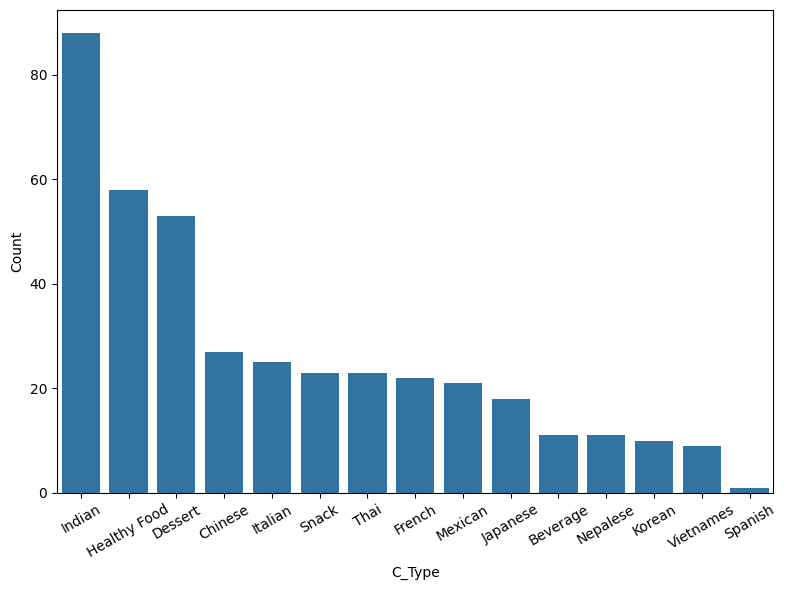

In [65]:
group_c_type = foods.groupby('C_Type')['C_Type'].agg('count').to_frame()
group_c_type = group_c_type.rename(columns={'C_Type': 'Count'})
group_c_type = group_c_type.sort_values(by='Count', ascending=False)
print(group_c_type.head(), '\n')

plt.figure(figsize=(8,6))

sns.barplot(x=group_c_type.index, y='Count', data=group_c_type)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Tipe masakan indian, healthy food, dan dessert merupakan top 3 untuk tipe masakan pada dataset.

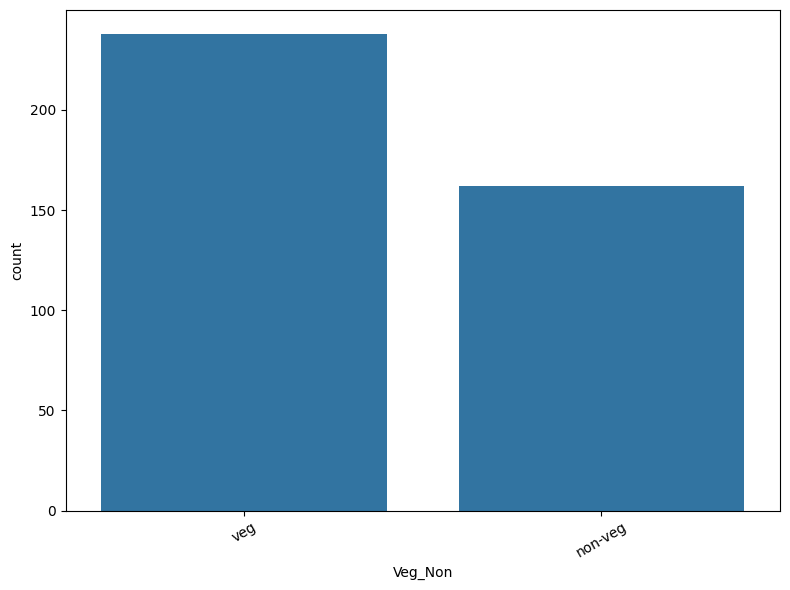

In [66]:
plt.figure(figsize=(8,6))

sns.countplot(x='Veg_Non', data=foods)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

**Ratings Datasets**

In [19]:
ratings.sample(5)

,User_ID,Food_ID,Rating
340,63.0,269.0,3.0
416,80.0,21.0,10.0
348,67.0,146.0,7.0
276,52.0,268.0,3.0
393,76.0,115.0,5.0


In [20]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_ID  511 non-null    float64
 1   Food_ID  511 non-null    float64
 2   Rating   511 non-null    float64
dtypes: float64(3)
memory usage: 12.1 KB


In [21]:
ratings.describe()

,User_ID,Food_ID,Rating
count,511.000000,511.000000,511.000000
mean,49.068493,125.311155,5.438356
std,28.739213,91.292629,2.866236
min,1.000000,1.000000,1.000000
25%,25.000000,45.500000,3.000000
50%,49.000000,111.000000,5.000000
75%,72.000000,204.000000,8.000000
max,100.000000,309.000000,10.000000


Dalam data, terdapat 511 baris data untuk fitur User_ID dan Food_ID, namun rentang nilai untuk masing-masing hanya mencakup 1 hingga 100 dan 1 hingga 309. Hal ini mengindikasikan bahwa beberapa pelanggan memberikan rating lebih dari sekali, begitu pula dengan makanan yang mendapatkan rating lebih dari sekali. Selain itu, fitur Rating menampilkan skala nilai dari 1 (terendah) hingga 10 (tertinggi).

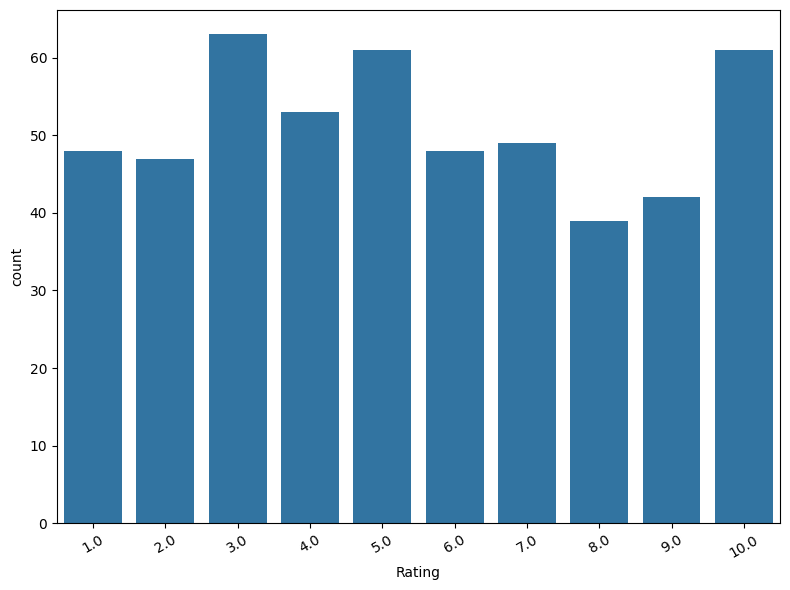

In [78]:
plt.figure(figsize=(8,6))

sns.countplot(x='Rating', data=ratings)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [83]:
rate_up = ratings[ratings['Rating'] >= 8]
rate_up['Food_ID'].value_counts().head(5)

49.0     3
7.0      3
186.0    3
136.0    2
25.0     2
Name: Food_ID, dtype: int64

In [84]:
rate_down = ratings[ratings['Rating'] <= 3]
rate_down['Food_ID'].value_counts().head(5)

23.0     4
49.0     3
22.0     3
163.0    3
225.0    2
Name: Food_ID, dtype: int64

## Content Based Filtering

## Collaborative Filtering

## Reference

[1] J. Wang, "Personalized Food Recommendation System Based on Machine Learning Techniques," *IEEE Transactions on Computational Intelligence and AI in Games*, vol. 8, no. 2, pp. 156-169, 2023.